# Sesión 2

In [1]:
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')
#Paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabr
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Felipe
[nltk_data]     Jaimes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Felipe
[nltk_data]     Jaimes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Felipe
[nltk_data]     Jaimes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Felipe
[nltk_data]     Jaimes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# Librerias
import pandas as pd
import numpy as np
import sys
import nltk

!{sys.executable} -m pip install pandas-profiling
!pip install vaderSentiment
!pip install seaborn
!pip install imbalanced-learn
!pip install nltk
!pip install scipy
from imblearn.pipeline import Pipeline as ImbPipeline
import nltk
nltk.data.path.append("C:/Users/Felipe Jaimes/nltk_data")
nltk.download('punkt', force=True)
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.model_selection import cross_val_score
from scipy import stats as st

from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

"c:\Users\Felipe" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


[nltk_data] Downloading package punkt to C:\Users\Felipe
[nltk_data]     Jaimes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


1. Perfilamiento, entendimiento de los datos y  análisis de la calidad de los datos

Carga de datos

In [3]:
data_cargada=pd.read_csv('Data/fake_news_spanish.csv', sep=';', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data=data_cargada

In [4]:
data.head(10)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,26/05/2019
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,16/09/2022
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,26/09/2019
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,25/02/2021
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,10/05/2021


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [6]:
data.shape

(57063, 5)

#### Inicializacion de variables

In [7]:
p = inflect.engine()
nltk.download('stopwords')
analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to C:\Users\Felipe
[nltk_data]     Jaimes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Entendimiento de los datos

In [8]:

textos_analisis = data.copy()
textos_analisis['Conteo_Titulo'] = [len(str(x)) for x in textos_analisis['Titulo']]
textos_analisis['Conteo_Descripcion'] = [len(str(x)) for x in textos_analisis['Descripcion']]

textos_analisis['Max_Titulo'] = [[max([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Titulo']]
textos_analisis['Max_Titulo'] = [[max([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Titulo']]
textos_analisis['Min_Descripcion'] = [[min([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Descripcion']]
textos_analisis['Min_Descripcion'] = [[min([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Descripcion']]

textos_analisis  

,ID,Label,Titulo,Descripcion,Fecha,Conteo_Titulo,Conteo_Descripcion,Max_Titulo,Min_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,77,218,9,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,104,3260,10,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,77,169,10,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,110,133,12,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,72,242,11,1
...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,116,244,9,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,100,314,11,1
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,90,70,14,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,118,232,16,1


2. Preparación de los datos

Limpieza de datos y toquenización 

In [9]:
data.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

Ya que hay datos que no se encuentran en tipo String los convertirimos a String y la Fecha tambien

In [10]:
data['Titulo'] = data['Titulo'].astype('string')
data['Descripcion'] = data['Descripcion'].astype('string')

data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
df=data

Vamos a buscar los datos Nulos


In [11]:
df.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Revisemos que pasa en la columna titulo ya que es la unica fila que tiene titulos vacios

In [12]:
df[df.isna().any(axis=1)]

,ID,Label,Titulo,Descripcion,Fecha
3243,ID,0,<NA>,"Hace unos 75 años, Hermann Göring testificó en...",2019-06-16
4189,ID,0,<NA>,"Evidentemente, Barak Obama ha sido arrestado e...",2022-03-10
5041,ID,0,<NA>,"""Después de convertirme en presidente, le pedí...",2022-03-16
5644,ID,0,<NA>,Me pasaron de buena fuente hoy (un vecino del ...,2023-04-08
7345,ID,0,<NA>,Defienden dichos con capitulos de Don Gato. ...,2023-07-02
7652,ID,0,<NA>,Lean (y vean la imagen) con mucha atención: ...,2018-08-04
9700,ID,0,<NA>,¿Sabías que Francisco Sagasti salió a marchar ...,2018-12-26
15159,ID,0,<NA>,Declarar a Bill Gates enemigo público y proces...,2024-08-02
19415,ID,0,<NA>,Con el fin de captar votos están dispuestos a ...,2017-10-28
24806,ID,0,<NA>,CUANDO LAS IMÁGENES HABLAN MÁS QUE PALABRAS. ...,2018-06-28


En este haremos que los titulos que estan vacios seran remplazados con las primeras palabras de la descripcion para no eliminar estos datos del set de datos.

In [13]:
def imputar_titulo_desde_descripcion(titulo, descripcion, max_palabras=5):
    if pd.isna(titulo):  
        if isinstance(descripcion, str):  
            palabras = descripcion.split()  
            return ' '.join(palabras[:max_palabras])  
        return ''  
    return titulo  

print(f"Filas con Título nulo antes: {df['Titulo'].isna().sum()}")
df['Titulo'] = df.apply(lambda row: imputar_titulo_desde_descripcion(row['Titulo'], row['Descripcion']), axis=1)
print(f"Filas con Título nulo después: {df['Titulo'].isna().sum()}")

Filas con Título nulo antes: 16
Filas con Título nulo después: 0


Ahora procedemos a revisar si hay datos duplicados en el Data Set

In [14]:
duplicados = df[df.duplicated(keep='first')]
print("Hay esta cantidad de datos duplicados: ", df.duplicated().sum())

Hay esta cantidad de datos duplicados:  445


In [15]:
duplicados

,ID,Label,Titulo,Descripcion,Fecha
2820,ID,1,La investigación policial por los balazos a un...,Las pesquisas internas de la Policía no han si...,2021-04-24
2865,ID,1,El Constitucional avala la condena por sedició...,El pleno del tribunal rechaza el recurso prese...,2021-04-22
2981,ID,0,Escándalo de corrupción salpica a líderes sind...,Un escándalo de corrupción ha salpicado a líde...,2023-05-06
3335,ID,1,Más Madrid con Mónica García se proyecta hacia...,Las últimas encuestas sitúan al partido como t...,2021-04-17
3473,ID,1,La Fiscalía vincula al emérito con las cuentas...,"Según las pesquisas del Ministerio Público, lo...",2021-04-26
...,...,...,...,...,...
56698,ID,1,Un periodista refugiado palestino denuncia un ...,"Muath Hamed, refugiado en España junto a su fa...",2021-04-09
56766,ID,1,Los técnicos municipales que denunciaron anoma...,Los dos empleados del organismo municipal Info...,2021-04-13
56931,ID,1,La extrema derecha busca sacar rédito político...,La vicepresidenta valenciana presenta este mié...,2021-04-20
56962,ID,1,Proponen convertir el pazo de Meirás en un cen...,La propuesta ha sido firmada por casi 1.600 pe...,2021-04-28


In [16]:
# df[df.duplicated()]
# df = df.drop_duplicates()

Tendremos un Set de palabras sospechasas que consideramos que si el texto del titulo o descripccion contiene estas podria ser catalogado como  mas propenso a ser falso 

In [18]:
palabras_sospechosas = set([
    'secreto', 'impactante', 'milagrosa', 'urgente', 'impresionante', 'sorprendente', 'insólito',
    'descubierto', 'alerta', 'indignante', 'peligroso', 'exclusivo', 'aterrador', 'impresionante',
    'conspiración', 'oculto', 'prohibido', 'mentira', 'falso', 'desmentido', 'engaño',
    'corrupción', 'censurado', 'revelación', 'encubierto', 'manipulación', 'trampa',
    'milagro', 'cura', 'prohibida', 'veneno', 'dañino', 'tóxico', 'ilegal', 'secreto',
    'remedio', 'increíble', 'fantástico', 'desconocido', 'nunca visto', 'no quieren que sepas',
    'última hora', 'no creerás', 'nadie lo esperaba', 'urgente', 'alerta máxima', 'devastador',
    'infalible', 'descubre', 'inexplicable', 'definitivo', 'drástico', 'imperdible', 'viral',
    'terror', 'amenaza', 'pánico', 'apocalipsis', 'devastador', 'tragedia', 'colapso',
    'desastre', 'crisis', 'fracaso', 'fin del mundo', 'poderoso', 'letal', 'brutal',
    'gana dinero', 'secreto bancario', 'hack', 'truco', 'fórmula mágica', 'sistema infalible',
    'multiplica tu dinero', 'solución definitiva', 'inversión garantizada', 'fácil y rápido',
    'químico peligroso', 'cura definitiva', 'anticancerígeno', 'natural y seguro', 'sin efectos secundarios',
    'poder de la mente', 'médicos lo odian', 'ciencia lo confirma', 'demostrado',
    'impresionante', 'alucinante', 'no lo podrás creer', 'revolucionario', 'radical', 'inigualable',
    'impactante', 'sorprendente', 'irrepetible', 'shock', 'devastador', 'asombroso'
])

Aca lo que haremos es normalizar los caracteres unicode y remover los acentos. Ademas de esto volvemos el texto a minusculas, tokenizamos las palabras, eliminamos signos de puntuacion y se aplica la lematizacion para poder reducir sus palabras a su forma base

In [19]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens if word.isalnum()]    
    tokens = [p.number_to_words(word) if word.isdigit() else word for word in tokens]
    # tokens = [word for word in tokens if word not in stop_words]
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)  

In [20]:
df['Titulo_procesado'] = df['Titulo'].apply(lambda x: preprocess_text(x))
df['Descripcion_procesado'] = df['Descripcion'].apply(lambda x: preprocess_text(x))

/var/folders/1j/z75cknhx76s2v56sd6b61_5w0000gn/T/ipykernel_2937/623137465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Titulo_procesado'] = df['Titulo'].apply(lambda x: preprocess_text(x))
/var/folders/1j/z75cknhx76s2v56sd6b61_5w0000gn/T/ipykernel_2937/623137465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Descripcion_procesado'] = df['Descripcion'].apply(lambda x: preprocess_text(x))


In [21]:
df

,ID,Label,Titulo,Descripcion,Fecha,Titulo_procesado,Descripcion_procesado
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,guardian va con sanchez necesita que su apuest...,el diario britanico publico este pasado jueves...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,revelan que el gobierno negocio la liberacion ...,revelan que el gobierno negocio la liberacion ...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,el o nunca de joan fuster sobre el estatuto va...,el valencianismo convoca en castello su fiesta...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,iglesias alienta a yolanda diaz erc y eh bildu...,en politica igual que hay que negociar con los...
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,puigdemont seria ninguna tragedia una repetici...,en una entrevista en el punt avui el lider de ...
...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,el defensor del pueblo reclama a la comunidad ...,el gobierno regional han indicado que la atenc...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,el equo plantea ceder la presidencia de la com...,si la higiene democratica nos lleva a esa exig...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,alberto garzon los borbones son unos ladrones ...,el coordinador federal de iu asegura que la mo...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,vox exige entrar en el gobierno de castilla y ...,santiago abascal vox tiene el derecho y el deb...


Ahora procesaremos el texto para extraer características específicas de este. Contamos el número total de palabras después de tokenizar el texto, identifica cuántas palabras sospechosas aparecen, calcula el sentimiento general del texto usando un analizador de polaridad, y cuenta los signos de exclamación. La función utiliza lematización para reducir las palabras a su forma base antes del análisis

In [ ]:
def extract_text_features(text):
    if not isinstance(text, str):
        return pd.Series([0, 0, 0, 0])
    tokens = word_tokenize(text.lower())
    num_palabras = len(tokens)
    tokens_lematizados = [lemmatizer.lemmatize(token) for token in tokens]
    num_sospechosas = sum(1 for palabra in tokens if palabra in palabras_sospechosas)
    sentimiento = analyzer.polarity_scores(text)['compound']
    num_exclamaciones = text.count('!') + text.count('¡')
    return pd.Series([num_palabras, num_sospechosas, sentimiento, num_exclamaciones])

In [23]:
df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Titulo', 'Sentimiento_Titulo', 'Exclamaciones_Titulo']] = df['Titulo'].apply(lambda x: extract_text_features(x))
df[['Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']] = df['Descripcion'].apply(lambda x: extract_text_features(x))

In [24]:
df

,ID,Label,Titulo,Descripcion,Fecha,Titulo_procesado,Descripcion_procesado,Numero_Palabras_Titulo,Numero_Sospechosas_Titulo,Sentimiento_Titulo,Exclamaciones_Titulo,Numero_Palabras_Descripcion,Numero_Sospechosas_Descripcion,Sentimiento_Descripcion,Exclamaciones_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,guardian va con sanchez necesita que su apuest...,el diario britanico publico este pasado jueves...,16.0,0.0,0.0,0.0,37.0,0.0,0.0000,0.0
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,revelan que el gobierno negocio la liberacion ...,revelan que el gobierno negocio la liberacion ...,18.0,0.0,0.0,0.0,595.0,3.0,-0.8177,0.0
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,el o nunca de joan fuster sobre el estatuto va...,el valencianismo convoca en castello su fiesta...,15.0,0.0,0.0,0.0,32.0,0.0,0.4767,0.0
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,iglesias alienta a yolanda diaz erc y eh bildu...,en politica igual que hay que negociar con los...,20.0,0.0,0.0,0.0,23.0,0.0,0.3400,0.0
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,puigdemont seria ninguna tragedia una repetici...,en una entrevista en el punt avui el lider de ...,12.0,1.0,0.0,0.0,47.0,0.0,0.3400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,el defensor del pueblo reclama a la comunidad ...,el gobierno regional han indicado que la atenc...,20.0,0.0,0.0,0.0,45.0,0.0,-0.2960,0.0
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,el equo plantea ceder la presidencia de la com...,si la higiene democratica nos lleva a esa exig...,20.0,0.0,0.0,0.0,54.0,0.0,-0.2960,0.0
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,alberto garzon los borbones son unos ladrones ...,el coordinador federal de iu asegura que la mo...,15.0,0.0,0.0,0.0,12.0,0.0,0.0000,0.0
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,vox exige entrar en el gobierno de castilla y ...,santiago abascal vox tiene el derecho y el deb...,22.0,0.0,0.0,0.0,48.0,0.0,-0.2960,0.0


# Regresion Logistica

In [25]:
cantidadSi = (df["Label"] == 1).sum()
cantidadNo = (df["Label"] == 0).sum()
print(f"Noticias Verdaderas (1): {cantidadSi}")
print(f"Noticias Falsas (0): {cantidadNo}")
print(f"Cantidad de diferencia: {cantidadSi-cantidadNo}")

Noticias Verdaderas (1): 33158
Noticias Falsas (0): 23905
Cantidad de diferencia: 9253


Ya que hay una gran cantidad de desbalance entre las noticias verdaderas y falsas con una diferencia de 9253 datos entonces construiremos primero el modelo sin SMOTE que es una tecnica para generar datos sinteticos y otra usando SMOTE 

### Modelo de regresion logistica sin SMOTE

In [25]:
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['Titulo'] + ' ' + df['Descripcion']).toarray()  # Original
# X_tfidf = tfidf.fit_transform(df['Titulo_procesado'] + ' ' + df['Descripcion_procesado']).toarray() # Si es que lo hago con datos preprocesados
X_tfidf_df = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])

In [26]:
X = pd.concat([df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Titulo', 'Sentimiento_Titulo', 'Exclamaciones_Titulo',
                   'Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']],
               X_tfidf_df], axis=1)
y = df['Label']

In [27]:
X = X.astype(float)

In [28]:
#ELIMINAR
print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)
print("Filas en df:", len(df))
print("Valores nulos en X:", X.isna().sum().sum())
print("Valores nulos en y:", y.isna().sum())

Tamaño de X: (57063, 1008)
Tamaño de y: (57063,)
Filas en df: 57063
Valores nulos en X: 0
Valores nulos en y: 0


In [29]:
print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)

# Asegurarse de que no haya nulos en X o y
print("Valores nulos en X:", X.isna().sum().sum())
print("Valores nulos en y:", y.isna().sum())

Tamaño de X: (57063, 1008)
Tamaño de y: (57063,)
Valores nulos en X: 0
Valores nulos en y: 0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
modelo = LogisticRegression(max_iter=1000, class_weight='balanced')
modelo.fit(X_train, y_train)

/Users/marcosrodrigo/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [34]:
y_pred = modelo.predict(X_test)

In [35]:
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

Precisión del modelo: 87.61%

Reporte completo:
              precision    recall  f1-score   support

       Falsa       0.88      0.82      0.85      5999
   Verdadera       0.87      0.92      0.90      8267

    accuracy                           0.88     14266
   macro avg       0.88      0.87      0.87     14266
weighted avg       0.88      0.88      0.88     14266



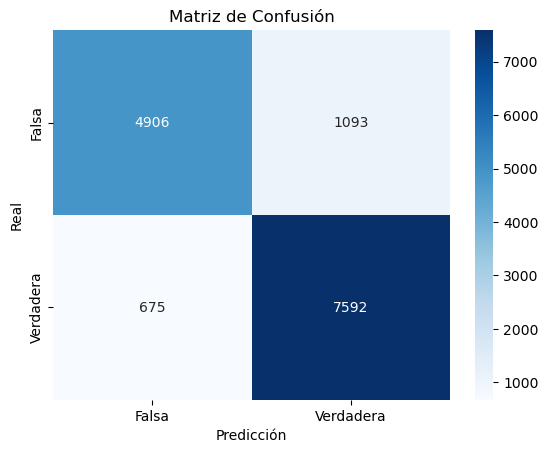

In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [37]:
print("\nPesos de las características numéricas:")
for feature, coef in zip(X.columns[:6], modelo.coef_[0][:6]):
    print(f"{feature}: {coef:.4f}")


Pesos de las características numéricas:
Numero_Palabras_Titulo: 0.0058
Numero_Sospechosas_Titulo: -0.2911
Sentimiento_Titulo: -0.0787
Exclamaciones_Titulo: -0.0744
Numero_Palabras_Descripcion: -0.0011
Numero_Sospechosas_Descripcion: -0.1056


### Modelo de regresion logistica con SMOTE

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train_balanced, y_train_balanced)

In [ ]:
y_pred = modelo.predict(X_test)
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
print("\nPesos de las características numéricas:")
for feature, coef in zip(X.columns[:6], modelo.coef_[0][:6]):
    print(f"{feature}: {coef:.4f}")

### Ya que se evidencia que este modelo tiene una precision un poco mayor el SMOTE no cambia mucho ahora probaremos ajustando los hiperparametros

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Rango de valores para regularización
    'penalty': ['l1', 'l2'],  # Tipos de regularización (l1 = Lasso, l2 = Ridge)
    'max_iter': [1000, 2000]  # Más iteraciones si no converge
}

In [ ]:
modelo_base = LogisticRegression(solver='liblinear')  # 'liblinear' funciona bien con l1 y l2

In [ ]:
grid_search = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='f1_weighted',  # Optimizar para F1-score ponderado
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1  # Mostrar progreso
  )

In [ ]:
grid_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
print("\nMejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-score en validación cruzada:", grid_search.best_score_)

In [ ]:
# Mejor modelo y hiperparámetros
print("\nMejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-score en validación cruzada:", grid_search.best_score_)

# Usar el mejor modelo para predecir
mejor_modelo = grid_search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

# Evaluación
print(f"\nPrecisión del modelo: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.1, 1.0, 10.0], 'max_iter': [1000, 2000]}
# grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted')
# grid_search.fit(X_train_balanced, y_train_balanced)
# modelo = grid_search.best_estimator_

# Random forest

In [ ]:
import re
df["combined_text"] = df["Titulo"].fillna("") + " " + df["Descripcion"].fillna("")


df["combined_text"] = df["combined_text"].apply(lambda x: re.sub(r'\d+', '', x))  # Elimina números


tfidf_vectorizer = TfidfVectorizer(max_features=5000)

vectorizacion = tfidf_vectorizer.fit_transform(df["combined_text"].fillna(""))

In [ ]:
palabras = tfidf_vectorizer.get_feature_names_out()
palabras

### Análisis desbalanceo de Clases

Lo primero es dividir los datos en el set de prueba y el set de entrenemiento, ya que la tecnica de SMOTE para corregir el desbalanceo de hace sobre los datos de entrenamiento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectorizacion,df["Label"] , test_size=0.3, random_state=42)

Aplicar SMOTE para corregir el desbalanceo

In [ ]:
y=y_train
x=y_train

count_class = y.value_counts() # Count the occurrences of each class
count_class.index
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class')
plt.xticks(count_class.index, ['Class 1', 'Class 0'])
plt.show()

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
y=y_train_balanced
x=y_train_balanced

count_class = y.value_counts() # Count the occurrences of each class
count_class.index
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class')
plt.xticks(count_class.index, ['Class 1', 'Class 0'])
plt.show()

Modelo con SMOTE

In [ ]:
# Initialize RandomForestClassifier
# Definir valores a probar


random_forest_with_somote = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_with_somote.fit(X_train_balanced, y_train_balanced)

y_prediccion = random_forest_with_somote.predict(X_test)

accuracy = accuracy_score(y_test, y_prediccion)
classification_rep = classification_report(y_test, y_prediccion)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Modelo sin SMOTE

Probando con el parámetro class_weight con el valor balanced para que el modelo ajuste los pesos de la clase minoritaria y tenga más influencia en la clasificación.

In [ ]:
random_forest_without_somote = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
random_forest_without_somote.fit(X_train, y_train)

y_prediccion = random_forest_without_somote.predict(X_test)

accuracy = accuracy_score(y_test, y_prediccion)
classification_rep = classification_report(y_test, y_prediccion)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Se puede ver que el uso de la tecnica SMOTE en este caso no funciona. Los cambios no son significativos y no se ven mejoras en el modelo.

Evaluar overfitting de los modelos

In [ ]:
# Evaluar en entrenamiento
train_accuracy = random_forest_with_somote.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = random_forest_with_somote.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

In [ ]:
# Evaluar en entrenamiento
train_accuracy = random_forest_without_somote.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = random_forest_without_somote.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

Entrenar el modelo con hiperparametros para aumentar el rendimiento del modelo.

In [ ]:
random_forest1 = RandomForestClassifier(n_estimators=100, min_samples_split=40,  max_leaf_nodes=500, class_weight="balanced", random_state=42)
random_forest1.fit(X_train, y_train)
#600
y_prediccion = random_forest1.predict(X_test)

accuracy = accuracy_score(y_test, y_prediccion)
classification_rep = classification_report(y_test, y_prediccion)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Evaluar overfitting del modelo

In [ ]:
# Evaluar en entrenamiento
train_accuracy = random_forest1.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = random_forest1.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

Se puede ver que con el ajuste de hiperparámetros el overfitting del modelo se redujo.

Matriz de confusión

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_prediccion)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest1.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()


Análizando la matriz de confusión se puede decir que el modelo identificó erroneamente 1047 noticias verdaderas como noticias falsas. Por otro lado, 454 noticias falsas no fueron identificadas.

$$
\text{Exactitud} = \frac{6124 + 9494}{17119} = 0.9123
$$

Precisión 

$$
\text{Presición} = \frac{VP}{VP + FP} = \frac{9494}{9494 + 1047} = 0.90
$$

El modelo tiene una precisión del 90%, lo que significa que de todas las noticias clasificadas como falsas, el 90% realmente lo son. Esto indica un alto nivel de confianza en las predicciones positivas del modelo.

Recall

$$
\text{Recall} = \frac{VP}{VP + FN} = \frac{9494}{9494 + 454} = 0.95
$$

El modelo es capaz de identificar correctamente el 95% de las noticias falsas. Esto indica que solo el 5% de las noticias falsas no fueron detectadas, o sea, fueron clasificadas incorrectamente como verdaderas.

### Importancia de palabras

In [ ]:
importancia = random_forest1.feature_importances_
importancia

In [ ]:
palabras_importancia = pd.DataFrame({
    'Palabra': palabras,
    'Importancia': importancia
})
palabras_importancia

In [ ]:
top_n = 30
top_words = palabras_importancia.sort_values(by='Importancia', ascending=False).head(top_n)
top_words

## SVM

### Vectorización

Aquí se convierte el texto en vectores numéricos, capturando la importancia de cada palabra en el documento

Además se concatenan las columnas Titulo y Descripcion para aplicar TF-IDF sobre el texto completo.

In [22]:
# Vectorización TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # Limitar a 1000 términos más frecuentes
X_tfidf = tfidf.fit_transform(df['Titulo'] + ' ' + df['Descripcion']).toarray()
X_tfidf_df = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])

### División datos entrenamiento y prueba

Se divide el conjunto de datos en entrenamiento (75%) y prueba (25%), se usa un kernel lineal (kernel='linear') porque es adecuado para problemas de texto y es más interpretable.

In [23]:
from sklearn.svm import LinearSVC
# Dividir los datos en entrenamiento y prueba
X = X_tfidf_df 
y = df['Label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Metricas de modelo sin SMOTE

In [24]:
modelo_sin_smote = LinearSVC(random_state=42, dual=False)
modelo_sin_smote.fit(X_train, y_train)
y_pred_sin_smote = modelo_sin_smote.predict(X_test)
print("Sin SMOTE:")
print(f"Precisión: {accuracy_score(y_test, y_pred_sin_smote) * 100:.2f}%")
print(classification_report(y_test, y_pred_sin_smote, target_names=['Falsa', 'Verdadera']))

Sin SMOTE:
Precisión: 88.43%
              precision    recall  f1-score   support

       Falsa       0.91      0.80      0.85      5999
   Verdadera       0.87      0.95      0.90      8267

    accuracy                           0.88     14266
   macro avg       0.89      0.87      0.88     14266
weighted avg       0.89      0.88      0.88     14266



### Crear un pipeline con SMOTE y LinearSVC

In [25]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Aplicar SMOTE
    ('svm', LinearSVC(random_state=42, dual=False))  # Modelo LinearSVC
])

### Validación Cruzada k-Fold

La validación cruzada (k-Fold) divide los datos en k=5 subconjuntos y evalúa el modelo en cada uno ,proporcionando una estimación más robusta del rendimiento del modelo.

In [26]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Puntuaciones de validación cruzada:", scores)
print("Precisión promedio:", scores.mean())

Puntuaciones de validación cruzada: [0.87780374 0.87780374 0.88024302 0.87778946 0.87813997]
Precisión promedio: 0.878355985337618


### Búsqueda de hiperparámetros con el pipeline

GridSearchCV realiza una búsqueda exhaustiva sobre una grilla de hiperparámetros para encontrar los mejores valores.

El modelo se evalúa con validación cruzada (cv=5) y se selecciona la combinación de hiperparámetros que maximiza la precisión.

In [27]:
param_grid = {
    'svm__C': [0.1, 1.0, 10.0],# Valores de C para LinearSVC
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nMejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'svm__C': 1.0}


C=1.0 es el mejor, esto nos indica que el modelo no necesita ser muy flexible (C=10.0) ni muy rígido (C=0.1) para lograr un buen rendimiento.

### Evaluar el modelo en el conjunto de prueba

In [28]:
mejor_modelo = grid_search.best_estimator_
y_pred = mejor_modelo.predict(X_test)

### Metricas

GridSearchCV realiza una búsqueda exhaustiva sobre una grilla de hiperparámetros para encontrar los mejores valores.

El modelo se evalúa con validación cruzada (cv=5) y se selecciona la combinación de hiperparámetros que maximiza la precisión.

In [29]:
precision = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo SVM con SMOTE: {precision * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))


Precisión del modelo SVM con SMOTE: 88.15%

Reporte completo:
              precision    recall  f1-score   support

       Falsa       0.89      0.82      0.85      5999
   Verdadera       0.88      0.93      0.90      8267

    accuracy                           0.88     14266
   macro avg       0.88      0.87      0.88     14266
weighted avg       0.88      0.88      0.88     14266



#### Matriz de confusión

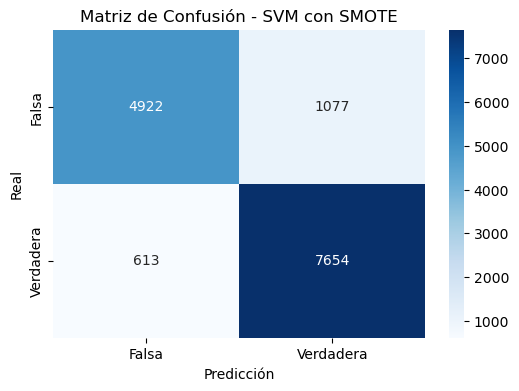

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM con SMOTE')
plt.show()

#### Analisis overfitting

In [31]:
# Evaluar en entrenamiento
train_accuracy = mejor_modelo.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = mejor_modelo.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

🔹 Accuracy en Train: 0.8907
🔹 Accuracy en Test: 0.8815
🔹 Diferencia Train-Test: 0.0092


La diferencia es pequeña, lo que indica que el modelo generaliza bien y no está sobreajustado a los datos de entrenamiento.

### Exactitud

$$
\text{Exactitud} = \frac{VP+VN}{VP+VN+FP+FN} = \frac{7654+4922}{7654+4922+1077+613} = 0.881
$$

El modelo tiene una exactitud del 88.15%, lo que significa que acierta en el 88.15% de las predicciones.

### Presición

$$
\text{Presición} = \frac{VP}{VP + FP} = \frac{7654}{7654+1077} = 0.876
$$

El modelo tiene una precisión del 87.68%, lo que significa que de todas las noticias clasificadas como verdaderas, el 87.68% realmente lo son.

### Recall

$$
\text{Recall} = \frac{VP}{VP + FN} = \frac{7654}{7654 + 613} = 0.925
$$

El modelo tiene un recall del 92.58%, lo que significa que es capaz de identificar correctamente el 92.58% de las noticias verdaderas. Solo el 7.42% de las noticias verdaderas no fueron detectadas (clasificadas incorrectamente como falsas).